In [1]:
import numpy as np
import pandas as pd 
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

In [2]:
from collections import defaultdict
import json

import scipy as sp

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'

/home/roop/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
#stock data can be obtained by google finance or yahoo finance easily and pandas provide an easy way to access it

In [4]:
import pandas_datareader.data as web
import datetime


In [5]:
#getting tata's stock data for a interval of jan17 till date
st = datetime.datetime(2014,1,1)
en = datetime.date.today()

In [6]:
apple_stocks=web.DataReader("AAPL", 'google', st, en)

In [7]:
apple_stocks.shape

(876, 5)

In [8]:
apple_stocks.columns

Index([u'Open', u'High', u'Low', u'Close', u'Volume'], dtype='object')

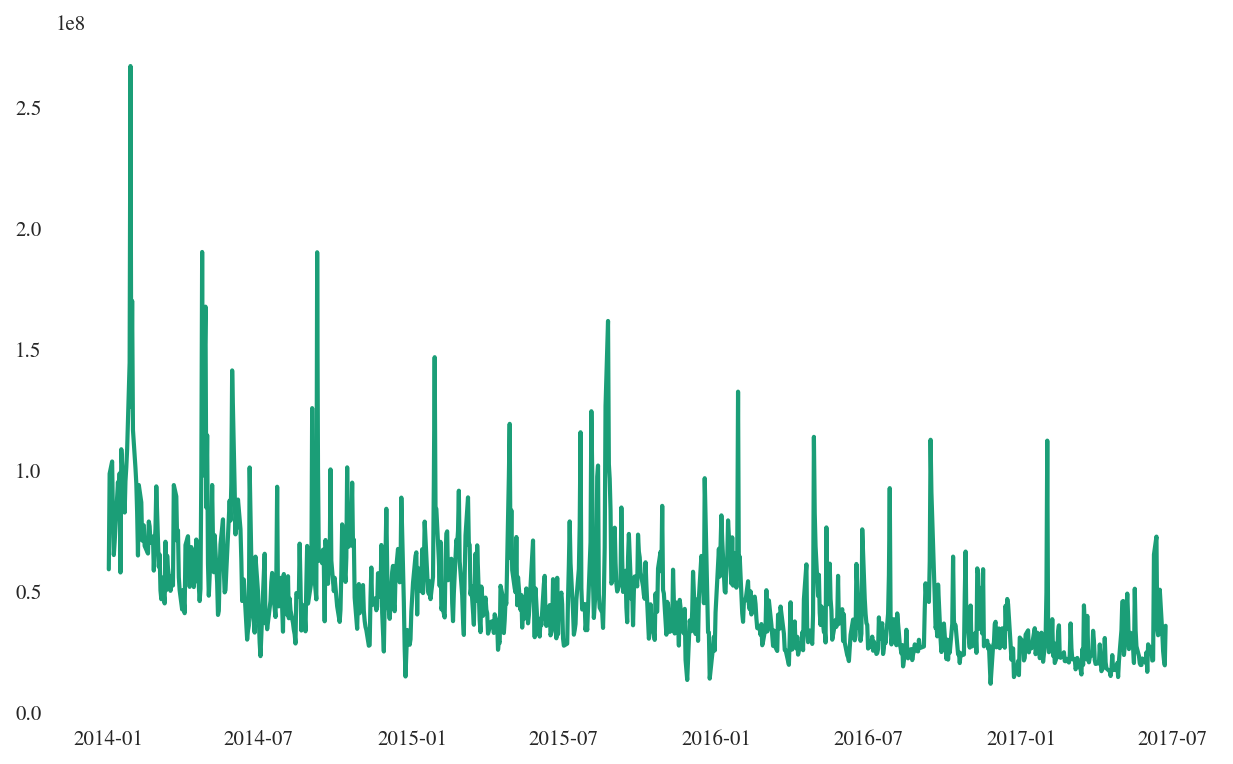

In [9]:
plt.plot(apple_stocks['Volume'])
plt.show()
#stocks traded is decreased in past years

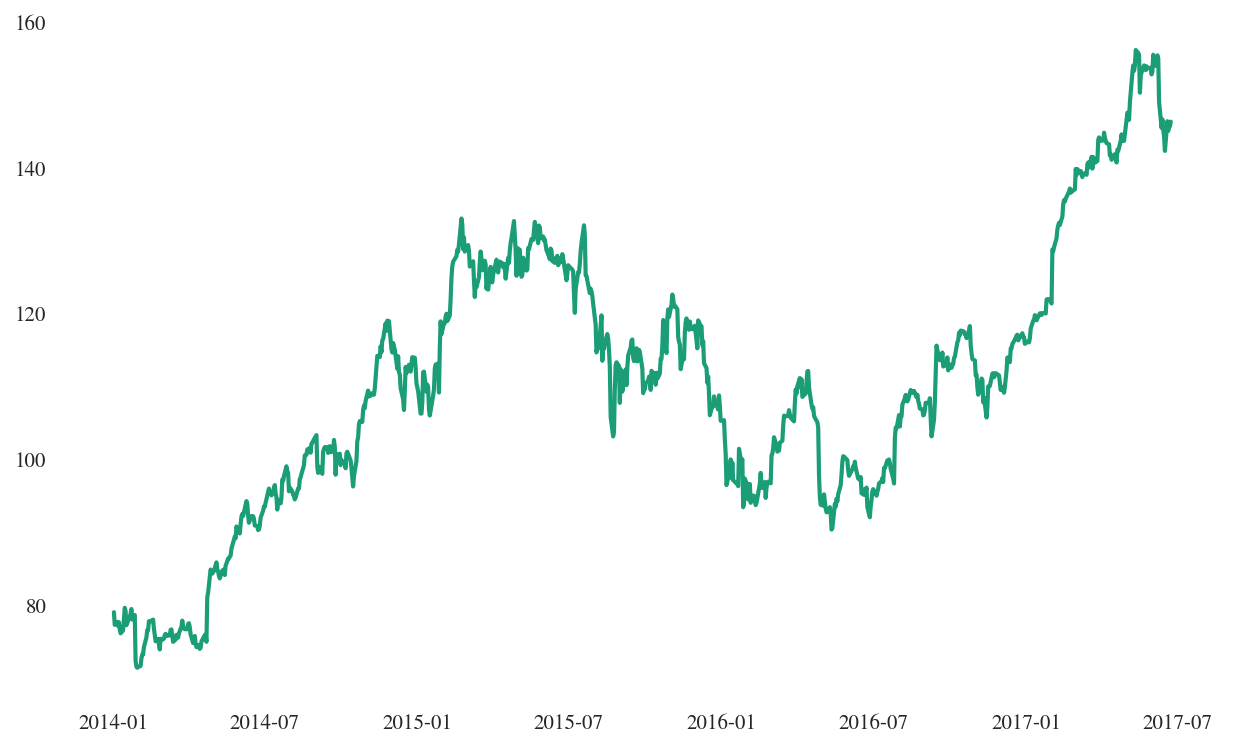

In [10]:
plt.plot(apple_stocks['Close'])
plt.show()

In [11]:
#candlestick plot is famous for stock prices
from matplotlib.dates import DateFormatter, WeekdayLocator,DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
from matplotlib.dates import date2num

In [12]:
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
    
    """
    mondays = WeekdayLocator(MONDAY)    
    alldays = DayLocator()              
    dayFormatter = DateFormatter('%d')
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 


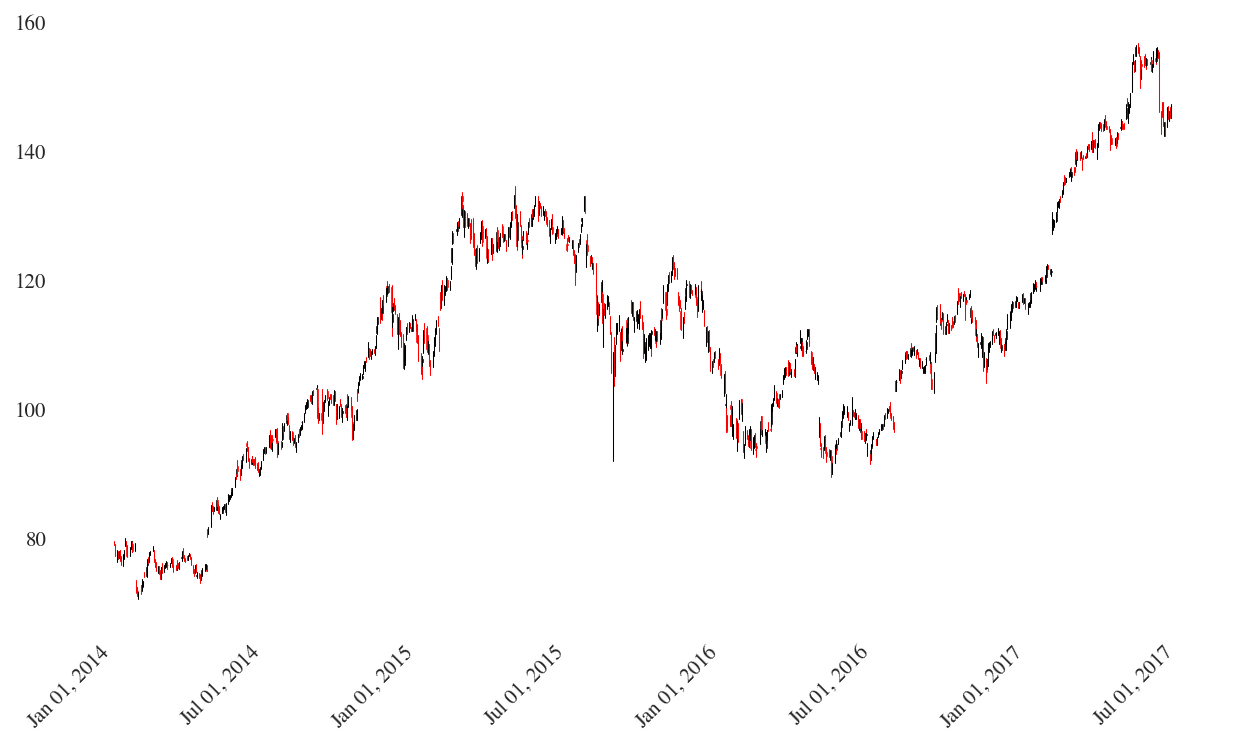

In [13]:
pandas_candlestick_ohlc(apple_stocks)

In [14]:
""" 
black candlestick - close price>open price
red candlestick - open price >close price
"""

' \nblack candlestick - close price>open price\nred candlestick - open price >close price\n'

In [15]:
#lets compare stock prices for different companies


In [16]:
#getting samsung stocks
samsung_stocks=web.DataReader("KRX:005930", 'google', st, en)


In [17]:
samsung_stocks.columns

Index([u'Open', u'High', u'Low', u'Close', u'Volume'], dtype='object')

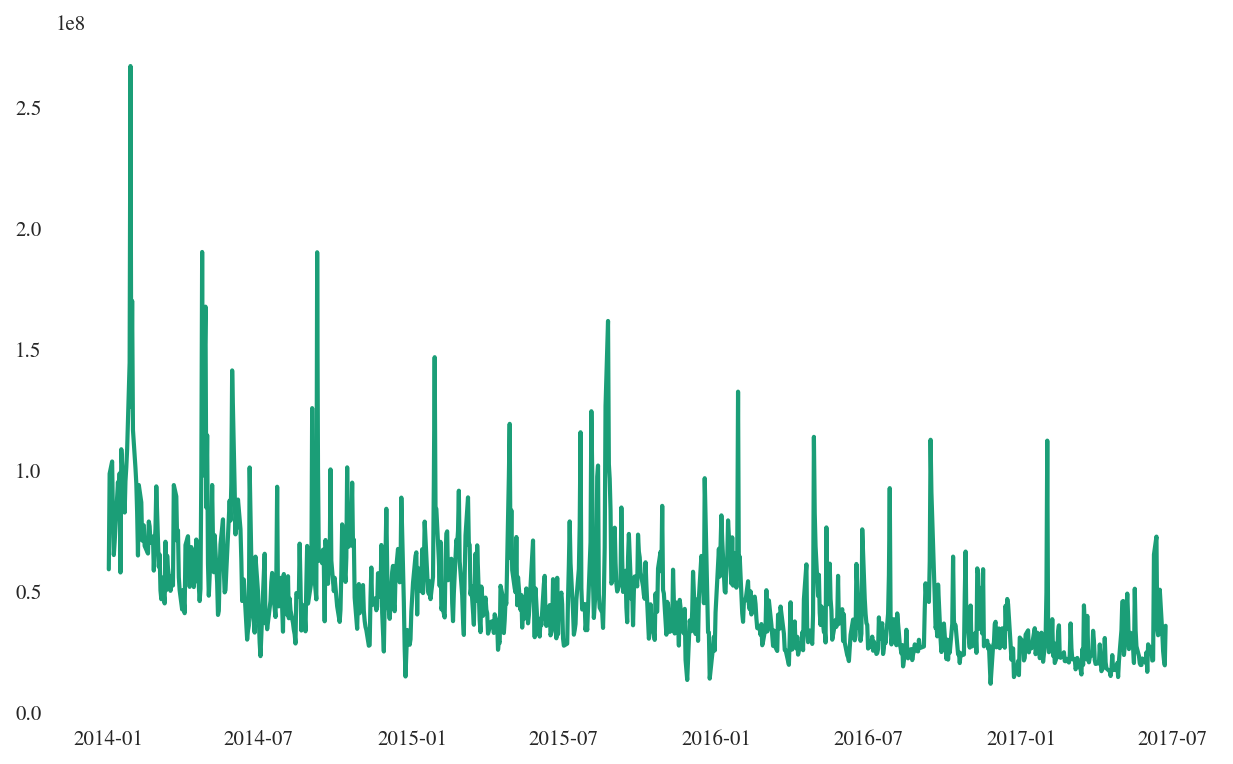

In [18]:
plt.plot(apple_stocks['Volume'])
plt.show()

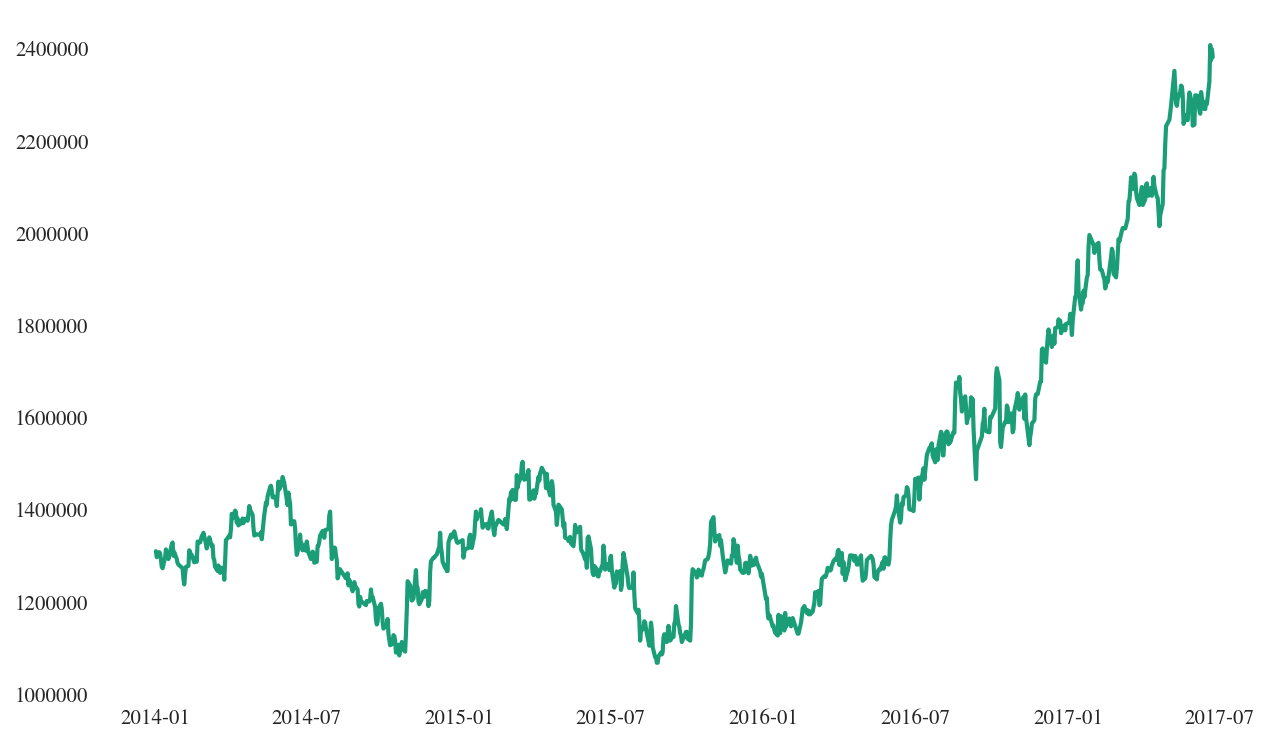

In [19]:
plt.plot(samsung_stocks['Close'])
plt.show()

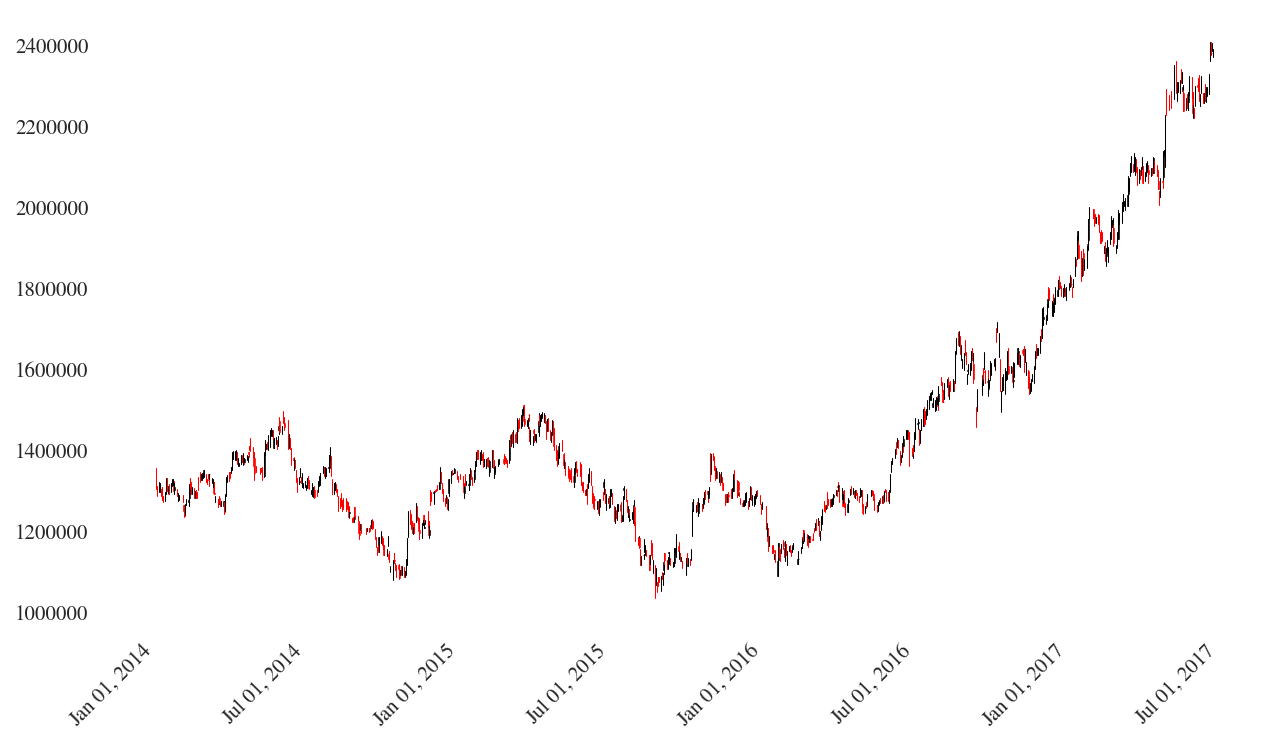

In [20]:
pandas_candlestick_ohlc(samsung_stocks)

In [21]:
#make combined dataframe
stocks=pd.DataFrame({'apple':apple_stocks['Close'],'samsung':samsung_stocks['Close']})

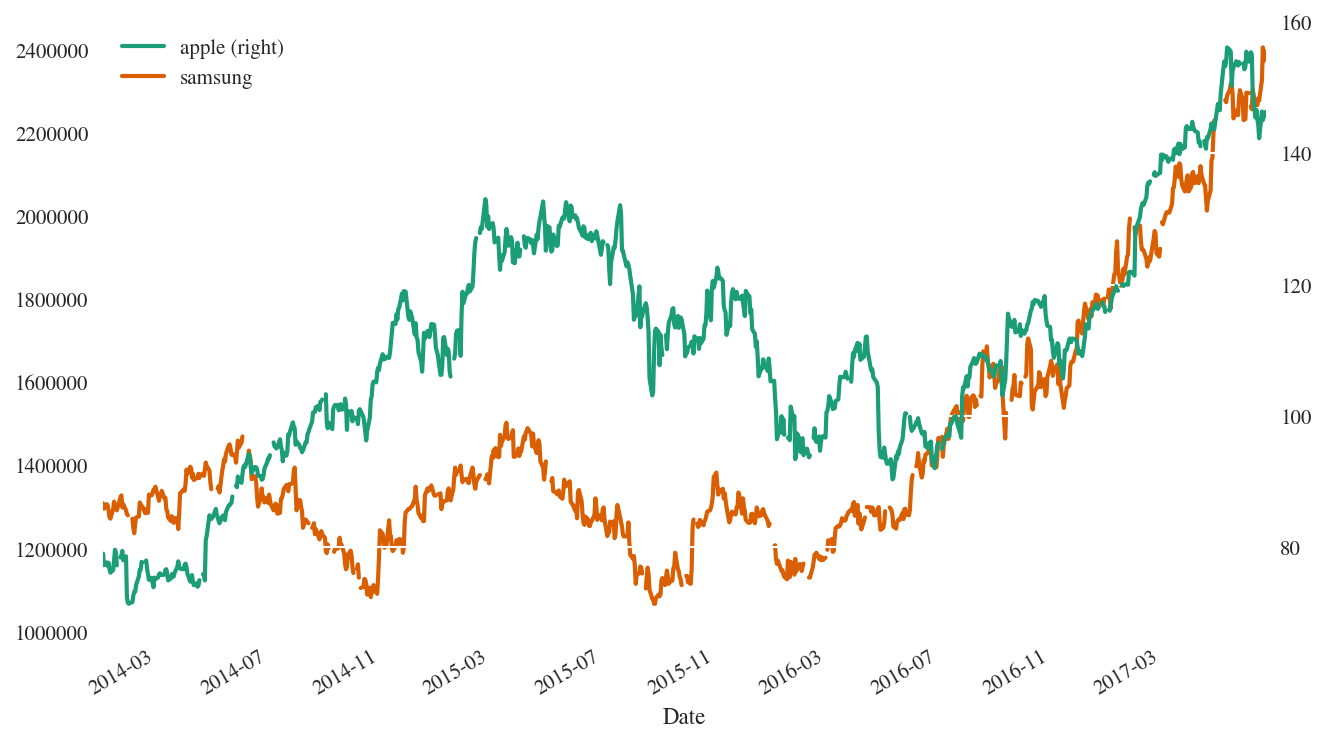

In [22]:
#both the stock prices are on different scale so pltting each graph on different scale so as to show relevancy
stocks.plot(secondary_y=["apple"],grid=True)
plt.show()


In [23]:
#plotting stock return which can be expressed as price(t)/price(0)
stocks_return=stocks.apply(lambda x:x/x[0])
stocks_return.head()

,apple,samsung
Date,,
2014-01-02,1.000000,1.000000
2014-01-03,0.977980,0.990069
2014-01-06,0.983295,0.998472
2014-01-07,0.976335,0.996180
2014-01-08,0.982536,0.986249


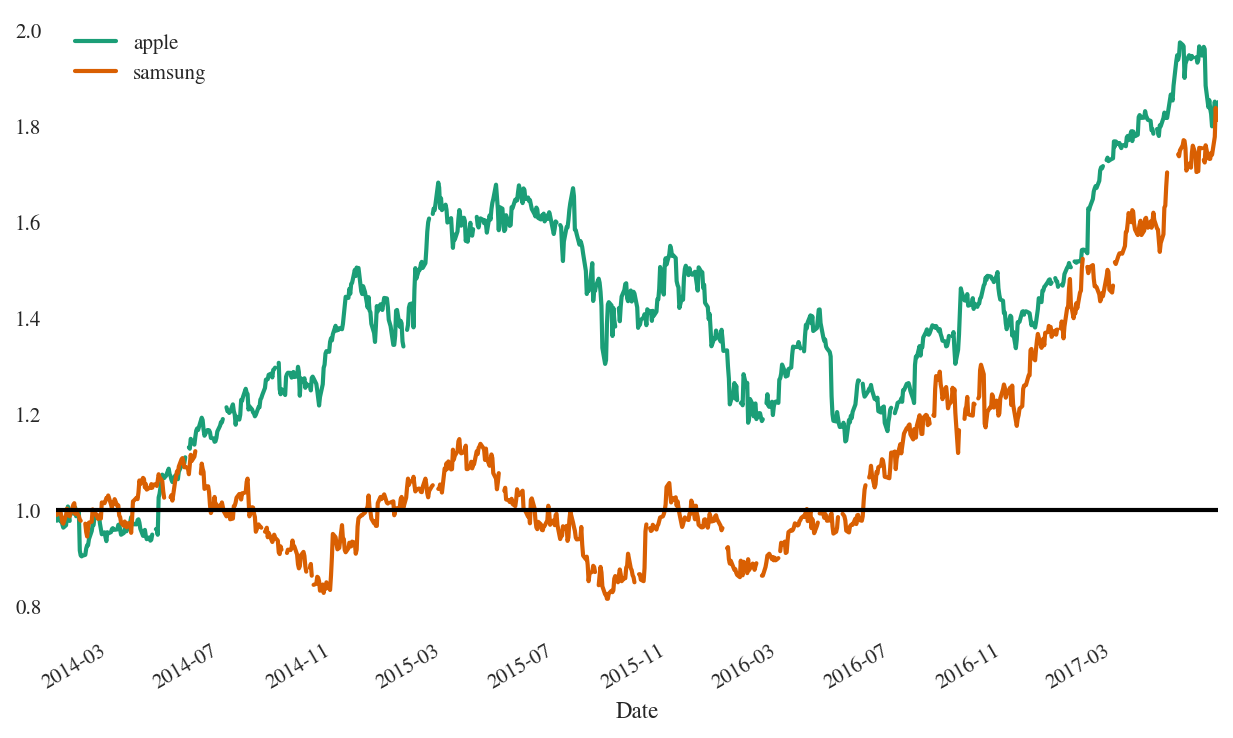

In [24]:
stocks_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)
plt.show()
#this shows that apple was more profitable since the beginning of the period

In [25]:
#lets plot change of each stock per day(using log to show change)
stocks_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) 
stocks_change.head()

,apple,samsung
Date,,
2014-01-02,NaN,NaN
2014-01-03,-0.022266,-0.009981
2014-01-06,0.005420,0.008452
2014-01-07,-0.007104,-0.002298
2014-01-08,0.006331,-0.010019


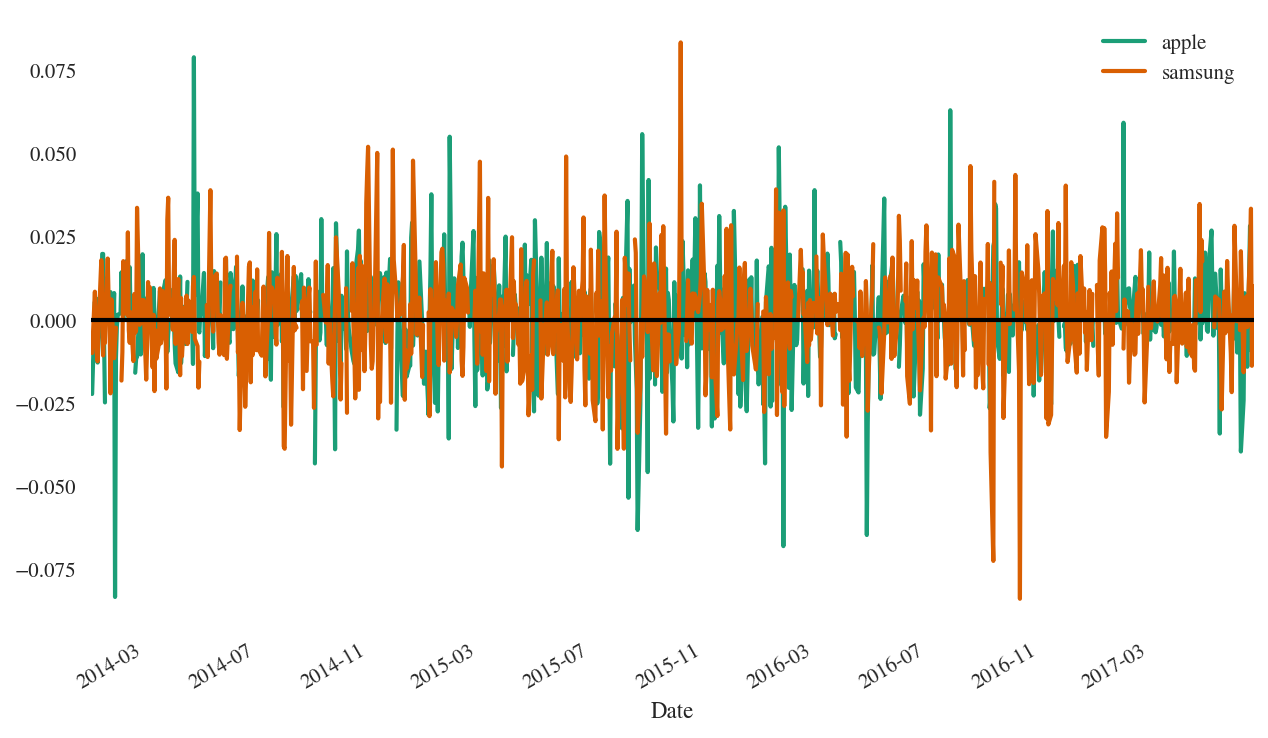

In [26]:
stocks_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)
plt.show()

In [27]:
#plotting moving averages


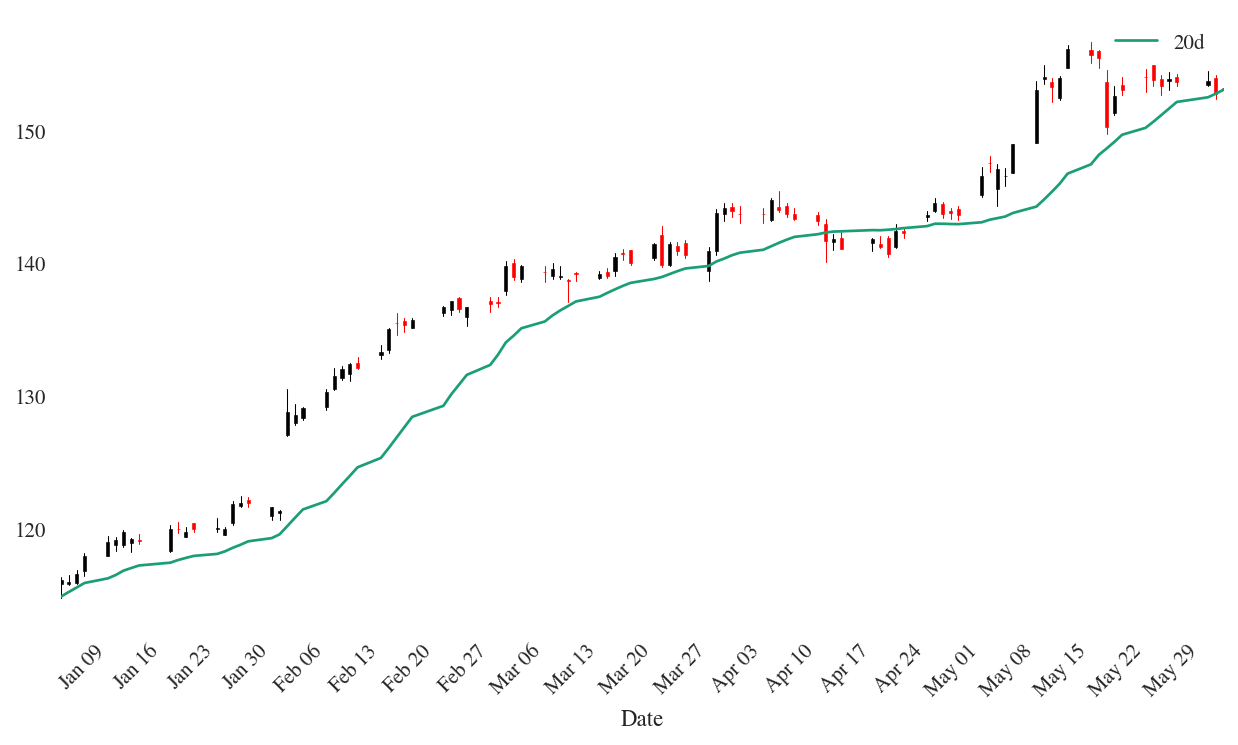

In [32]:
apple_stocks["20d"] = np.round(apple_stocks["Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(apple_stocks.loc['2017-01-01':'2017-06-01',:], otherseries = "20d")

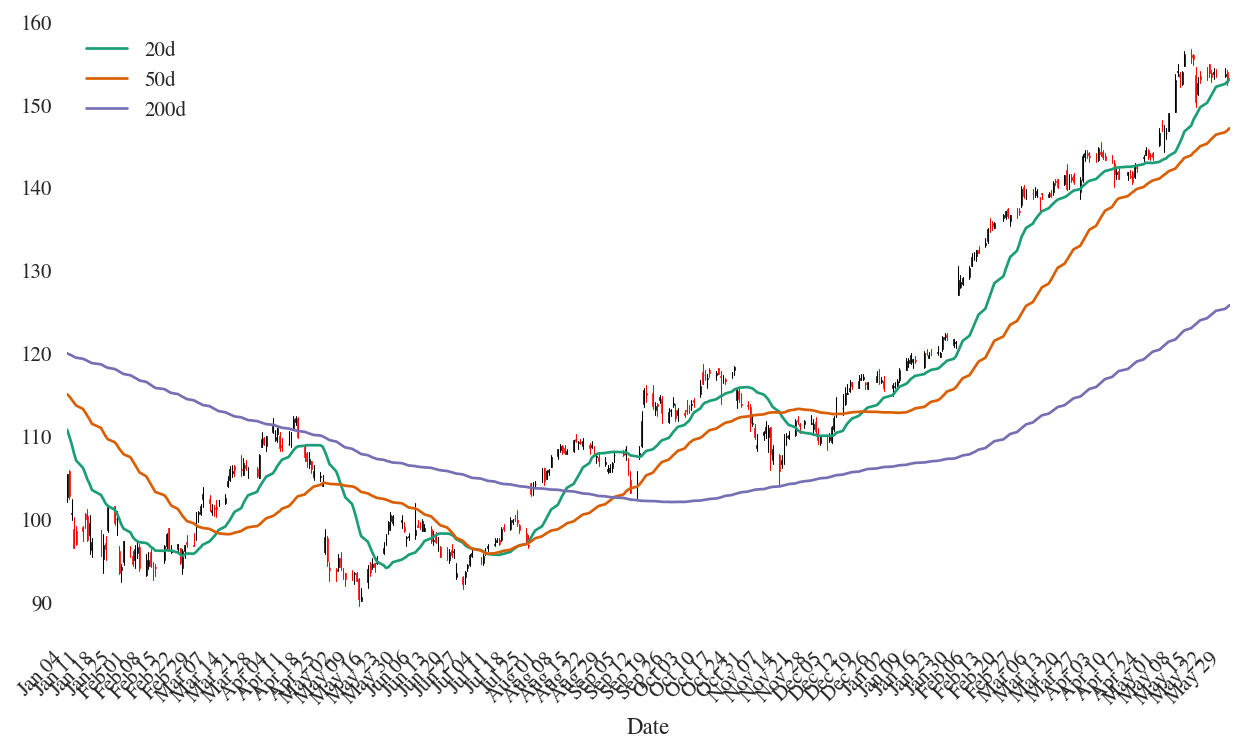

In [37]:
apple_stocks["50d"] = np.round(apple_stocks["Close"].rolling(window = 50, center = False).mean(), 2)
apple_stocks["200d"] = np.round(apple_stocks["Close"].rolling(window = 200, center = False).mean(), 2)
 
pandas_candlestick_ohlc(apple_stocks.loc['2016-01-01':'2017-06-01',:], otherseries = ["20d", "50d", "200d"])

In [ ]:
#the 200 day moving average shows the overall trend of the stock price
#according to 200 day average the apple's stock price fall till Oct amd then started rising
#20 day moving average is more sensitive for day fluctuations


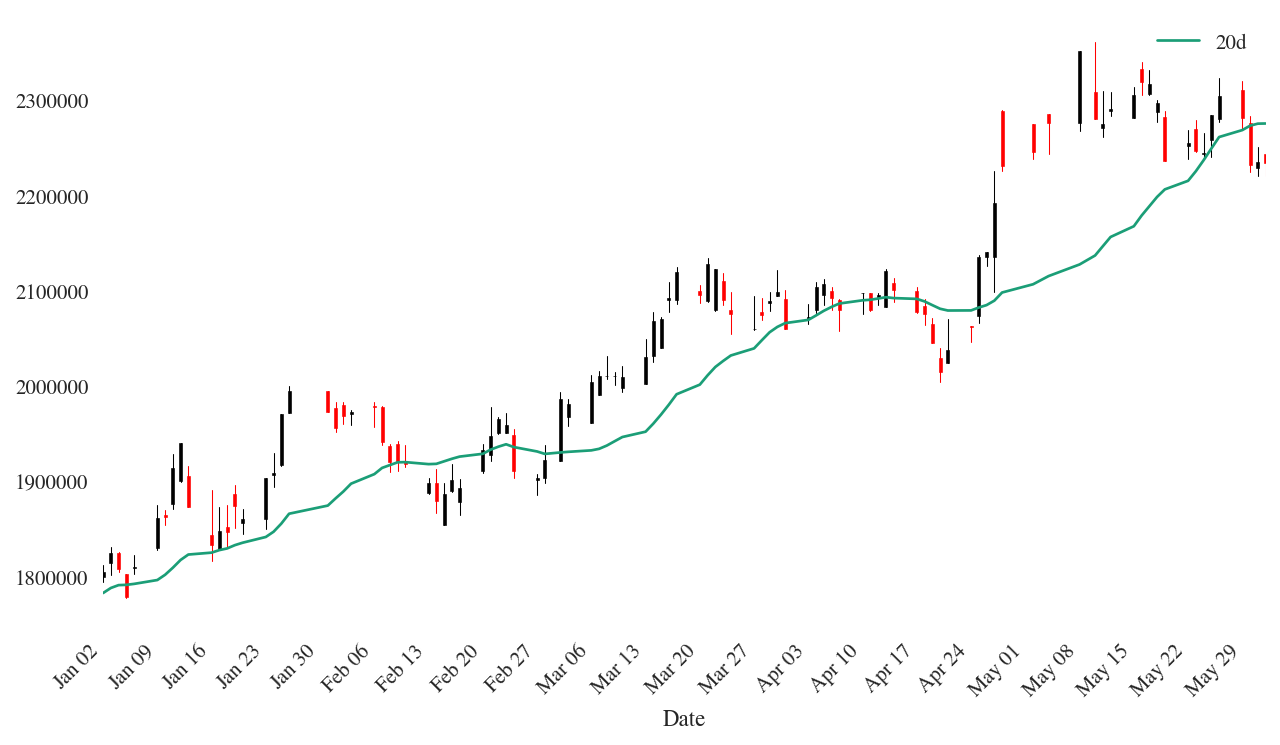

In [34]:
#moving averages of samsung
samsung_stocks["20d"] = np.round(samsung_stocks["Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(samsung_stocks.loc['2017-01-01':'2017-06-01',:], otherseries = "20d")

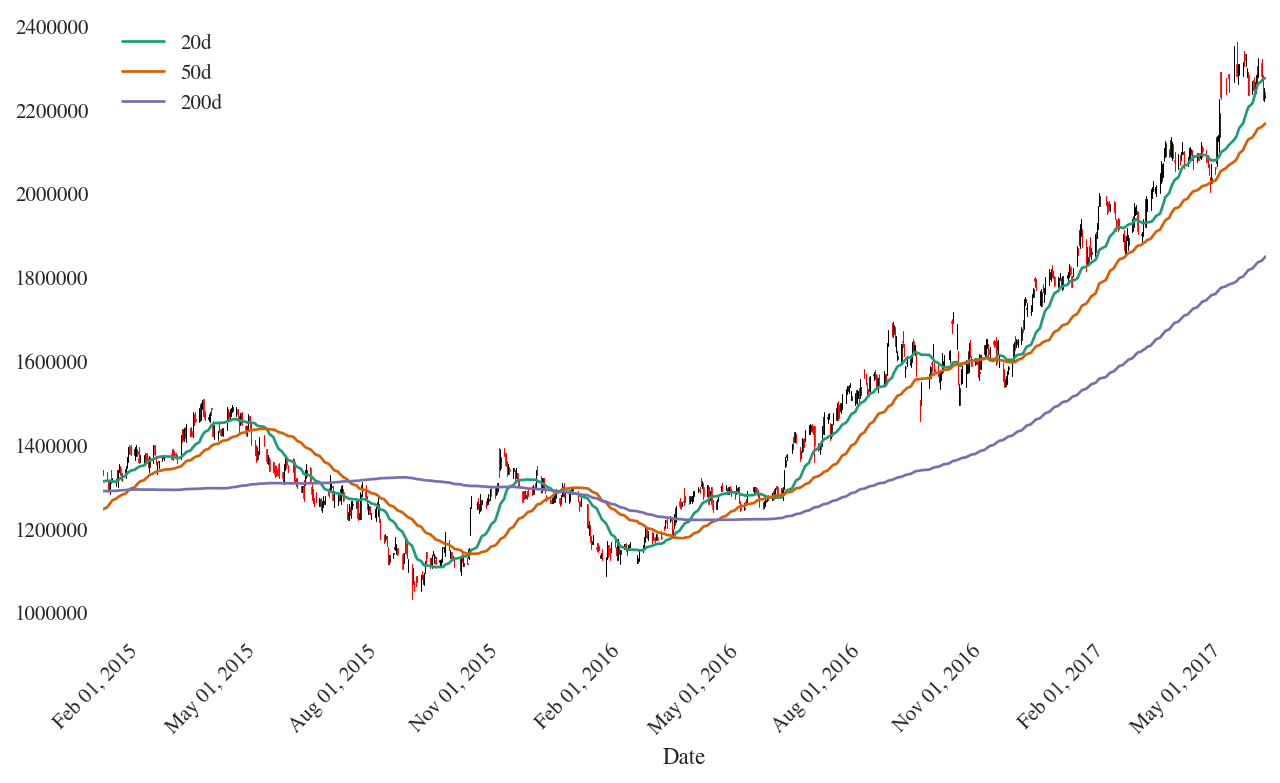

In [39]:
samsung_stocks["50d"] = np.round(samsung_stocks["Close"].rolling(window = 50, center = False).mean(), 2)
samsung_stocks["200d"] = np.round(samsung_stocks["Close"].rolling(window = 200, center = False).mean(), 2)
 
pandas_candlestick_ohlc(samsung_stocks.loc['2015-01-01':'2017-06-01',:], otherseries = ["20d", "50d", "200d"])

In [40]:
#the 200 day moving average shows a good rise in samsung stock price after Aug 2016 after a stable time since 2015